In [561]:
# import libraries
import pandas as pd
import json 
import numpy as np
from sklearn.cluster import OPTICS
from scipy.spatial.distance import euclidean as d_euclidean

import pickle
import os
import warnings
import threading
import queue
import time
from multiprocessing import Process, Manager
from numba import jit

## Matriz de distancias

In [562]:
def slope_to_rotation_matrix(slope):
    
    return np.array([[1, slope], [-slope, 1]])

In [563]:
def get_point_projection_on_line(point, line):

    line_slope = (line[-1, 1] - line[0, 1]) / (line[-1, 0] - line[0, 0]) if line[-1, 0] != line[0, 0] else np.inf

    if np.isinf(line_slope):
        return np.array([line[0,0], point[1]])
    
    R = slope_to_rotation_matrix(line_slope)

    rot_line = np.matmul(line, R.T)
    rot_point = np.matmul(point, R.T)

    proj = np.array([rot_point[0], rot_line[0,1]])

    R_inverse = np.linalg.inv(R)
    proj = np.matmul(proj, R_inverse.T)

    return proj

In [564]:
def d_perpendicular(l1, l2):

    l_shorter = l_longer = None
    l1_len, l2_len = d_euclidean(l1[0], l1[-1]), d_euclidean(l2[0], l2[-1])
    if l1_len < l2_len:
        l_shorter = l1
        l_longer = l2
    else:
        l_shorter = l2
        l_longer = l1

    ps = get_point_projection_on_line(l_shorter[0], l_longer)
    pe = get_point_projection_on_line(l_shorter[-1], l_longer)

    lehmer_1 = d_euclidean(l_shorter[0], ps)
    lehmer_2 = d_euclidean(l_shorter[-1], pe)

    if lehmer_1 == 0 and lehmer_2 == 0:
        return 0
    return (lehmer_1**2 + lehmer_2**2) / (lehmer_1 + lehmer_2)

In [565]:
def d_parallel(l1, l2):
    
    l_shorter = l_longer = None
    l1_len, l2_len = d_euclidean(l1[0], l1[-1]), d_euclidean(l2[0], l2[-1])
    if l1_len < l2_len:
        l_shorter = l1
        l_longer = l2
    else:
        l_shorter = l2
        l_longer = l1

    ps = get_point_projection_on_line(l_shorter[0], l_longer)
    pe = get_point_projection_on_line(l_shorter[-1], l_longer)

    parallel_1 = min(d_euclidean(l_longer[0], ps), d_euclidean(l_longer[-1], ps))
    parallel_2 = min(d_euclidean(l_longer[0], pe), d_euclidean(l_longer[-1], pe))

    return min(parallel_1, parallel_2)

In [566]:
def d_angular(l1, l2, directional=True):

    l_shorter = l_longer = None
    l1_len, l2_len = d_euclidean(l1[0], l1[-1]), d_euclidean(l2[0], l2[-1])
    if l1_len < l2_len:
        l_shorter = l1
        l_longer = l2
    else:
        l_shorter = l2
        l_longer = l1

    shorter_slope = (l_shorter[-1,1] - l_shorter[0,1]) / (l_shorter[-1,0] - l_shorter[0,0]) if l_shorter[-1,0] - l_shorter[0,0] != 0 else np.inf
    longer_slope = (l_longer[-1,1] - l_longer[0,1]) / (l_longer[-1,0] - l_longer[0,0]) if l_longer[-1,0] - l_longer[0,0] != 0 else np.inf

    theta = None
    if np.isinf(shorter_slope):
        tan_theta0 = longer_slope
        tan_theta1 = tan_theta0 * -1
        theta0 = np.abs(np.arctan(tan_theta0))
        theta1 = np.abs(np.arctan(tan_theta1))
        theta = min(theta0, theta1)
    elif np.isinf(longer_slope):
        tan_theta0 = shorter_slope
        tan_theta1 = tan_theta0 * -1
        theta0 = np.abs(np.arctan(tan_theta0))
        theta1 = np.abs(np.arctan(tan_theta1))
        theta = min(theta0, theta1)
    else:
        tan_theta0 = (shorter_slope - longer_slope) / (1 + shorter_slope * longer_slope)
        tan_theta1 = tan_theta0 * -1

        theta0 = np.abs(np.arctan(tan_theta0))
        theta1 = np.abs(np.arctan(tan_theta1))

        theta = min(theta0, theta1)

    if directional:
        return np.sin(theta) * d_euclidean(l_longer[0], l_longer[-1])

    if 0 <= theta < (90 * np.pi / 180):
        return np.sin(theta) * d_euclidean(l_longer[0], l_longer[-1])
    elif (90 * np.pi / 180) <= theta <= np.pi:
        return np.sin(theta)
    else:
        raise ValueError("Theta is not in the range of 0 to 180 degrees.")

In [567]:
def distance(l1, l2, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1):

    perpendicular_distance = d_perpendicular(l1, l2)
    parallel_distance = d_parallel(l1, l2)
    angular_distance = d_angular(l1, l2, directional=directional)

    # print(f'Progreso: {i+1}/{n_partitions}', end='\r')

    return (w_perpendicular * perpendicular_distance) + (w_parallel * parallel_distance) + (w_angular * angular_distance)

In [568]:
def get_distance_matrix(partitions, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1, progress_bar=False):
    
    n_partitions = len(partitions)
    dist_matrix = np.zeros((n_partitions, n_partitions))
    
    for i in range(n_partitions):
        if progress_bar: print(f'Progreso: {i+1}/{n_partitions}', end='\r')
        for j in range(i+1):
            # print('i: ', partitions[i], ' j: ', partitions[j])
            dist_matrix[i,j] = dist_matrix[j,i] = distance(partitions[i], partitions[j], directional=directional, w_perpendicular=w_perpendicular, w_parallel=w_parallel, w_angular=w_angular)
            if progress_bar: print(f'Progreso: {i+1}/{n_partitions}', end='\r')

    for i in range(n_partitions):
        dist_matrix[i,i] = 0

    if np.isnan(dist_matrix).any():
        warnings.warn("La matriz de distancias contiene valores NaN")
        dist_matrix[np.isnan(dist_matrix)] = 9999999

    return dist_matrix

## Particiones

In [569]:
def partition2segments(partition):

    if not isinstance(partition, np.ndarray):
        raise TypeError("partition must be of type np.ndarray")
    elif partition.shape[1] != 2:
        raise ValueError("partition must be of shape (n, 2)")
    
    segments = []
    for i in range(partition.shape[0]-1):
        segments.append(np.array([[partition[i, 0], partition[i, 1]], [partition[i+1, 0], partition[i+1, 1]]]))

    return segments

In [570]:
def minimum_desription_length(start_idx, curr_idx, trajectory, w_angular=1, w_perpendicular=1, par=True, directional=True):
    
    LH = LDH = 0
    for i in range(start_idx, curr_idx-1):
        ed = d_euclidean(trajectory[i], trajectory[i+1])
        LH += max(0, np.log2(ed, where=ed>0))
        if par:
            for j in range(start_idx, i-1):
                LDH += w_perpendicular * d_perpendicular(np.array([trajectory[start_idx], trajectory[i]]), np.array([trajectory[j], trajectory[j+1]]))
                LDH += w_angular * d_angular(np.array([trajectory[start_idx], trajectory[i]]), np.array([trajectory[j], trajectory[j+1]]), directional=directional)
    if par:
        return LH + LDH
    return LH

In [571]:
def partition(trajectory, directional=True, progress_bar=False, w_perpendicular=1, w_angular=1):
    
    if not isinstance(trajectory, np.ndarray):
        raise TypeError("La trayectoria debe ser un arreglo de NumPy")
    elif trajectory.shape[1] != 2:
        raise ValueError("La trayectoria debe tener la forma (n, 2)")
    
    cp_indices = [0]

    traj_len = trajectory.shape[0]
    start_idx = 0  
    
    length = 1  
    while start_idx + length < traj_len: 
        if progress_bar:
            print(f'\r{round(((start_idx + length) / traj_len) * 100, 2)}%', end='')
        
        curr_idx = start_idx + length 

        cost_par = minimum_desription_length(start_idx, curr_idx, trajectory, w_angular=w_angular, w_perpendicular=w_perpendicular, directional=directional)
        cost_nopar = minimum_desription_length(start_idx, curr_idx, trajectory, par=False, directional=directional)

        if cost_par > cost_nopar: 
            cp_indices.append(curr_idx-1)  
            start_idx = curr_idx-1
            length = 1
        else:
            length += 1 

    cp_indices.append(len(trajectory) - 1)

    return np.array([trajectory[i] for i in cp_indices])

## Representacion de trayecorias

In [572]:
def get_average_direction_slope(line_list):

    slopes = []
    for line in line_list:
        slopes.append((line[-1, 1] - line[0, 1]) / (line[-1, 0] - line[0, 0]) if (line[-1, 0] - line[0, 0]) != 0 else 0)
    slopes = np.array(slopes)

    return np.mean(slopes)

In [573]:
def get_representative_trajectory(lines, min_lines=3):
    
    average_slope = get_average_direction_slope(lines)
    rotation_matrix = slope_to_rotation_matrix(average_slope)

    rotated_lines = []
    for line in lines:
        rotated_lines.append(np.matmul(line, rotation_matrix.T))

    starting_and_ending_points = []
    for line in rotated_lines:
        starting_and_ending_points.append(line[0])
        starting_and_ending_points.append(line[-1])
    starting_and_ending_points = np.array(starting_and_ending_points)

    starting_and_ending_points = starting_and_ending_points[starting_and_ending_points[:, 0].argsort()]

    representative_points = []
    for p in starting_and_ending_points:
        num_p = 0
        for line in rotated_lines:
            point_sorted_line = line[line[:, 0].argsort()]
            if point_sorted_line[0, 0] <= p[0] <= point_sorted_line[-1, 0]:
                num_p += 1

        if num_p >= min_lines:
            y_avg = 0
            for line in rotated_lines:
                point_sorted_line = line[line[:, 0].argsort()]
                if point_sorted_line[0, 0] <= p[0] <= point_sorted_line[-1, 0]:
                    y_avg += (point_sorted_line[0, 1] + point_sorted_line[-1, 1]) / 2
            y_avg /= num_p
            representative_points.append(np.array([p[0], y_avg]))

    if len(representative_points) == 0:
        warnings.warn("ADVERTENCIA: No se encontraron puntos representativos.")
        return np.array([])

    representative_points = np.array(representative_points)
    representative_points = np.matmul(representative_points, np.linalg.inv(rotation_matrix).T)

    return representative_points

## TRACLUS

In [574]:
def traclus(trajectories, max_eps=None, min_samples=10, directional=True, use_segments=True, clustering_algorithm=OPTICS, mdl_weights=[1,1,1], d_weights=[1,1,1], progress_bar=False):

    # Check input
    if not isinstance(trajectories, list):
        raise TypeError("Trajectories must be a list")
    for trajectory in trajectories:
        if not isinstance(trajectory, np.ndarray):
            raise TypeError("Trajectories must be a list of numpy arrays")
        elif len(trajectory.shape) != 2:
            raise ValueError("Trajectories must be a list of numpy arrays of shape (n, 2)")
        elif trajectory.shape[1] != 2:
            raise ValueError("Trajectories must be a list of numpy arrays of shape (n, 2)")

    # Partition trajectories
    if progress_bar:
        print("Partitioning trajectories...")
    partitions = []
    i = 0
    for trajectory in trajectories:
        if progress_bar:
            print(f"\rTrajectory {i + 1}/{len(trajectories)}", end='')
            i += 1
        partitions.append(partition(trajectory, directional=directional, progress_bar=False, w_perpendicular=mdl_weights[0], w_angular=mdl_weights[2]))
    if progress_bar:
        print()

    # Convert partitions to segments
    segments = []
    if use_segments:
        if progress_bar:
            print("Converting partitioned trajectories to segments...")
        i = 0
        for parts in partitions:
            if progress_bar:
                print(f"\rPartition {i + 1}/{len(parts)}", end='')
            segments += partition2segments(parts)
    else:
        segments = partitions

    # Get distance matrix
    dist_matrix = get_distance_matrix(segments, directional=directional, w_perpendicular=d_weights[0], w_parallel=d_weights[1], w_angular=d_weights[2], progress_bar=progress_bar)

    # Cluster segments
    if progress_bar:
        print("Grouping partitions...")
    clusters = []
    clustering_model = None
    if max_eps is not None:
        clustering_model = clustering_algorithm(max_eps=max_eps, min_samples=min_samples)
    else:
        clustering_model = clustering_algorithm(min_samples=min_samples)
    cluster_assignments = clustering_model.fit_predict(dist_matrix)
    for c in range(min(cluster_assignments), max(cluster_assignments) + 1):
        clusters.append([segments[i] for i in range(len(segments)) if cluster_assignments[i] == c])

    if progress_bar:
        print()

    # Get representative trajectories
    if progress_bar:
        print("Getting representative trajectories...")
    representative_trajectories = []
    for cluster in clusters:
        representative_trajectories.append(get_representative_trajectory(cluster))
    if progress_bar:
        print()

    return partitions, segments, dist_matrix, clusters, cluster_assignments, representative_trajectories

## Comprobaciones de rendimiento

In [575]:
# Variables globales
nrows = 500
# Ruta del archivo CSV
filename = "C:/Users/Álvaro/Documents/GitHub/TFG/TFG_TRACLUS/app/train_data/taxis_trajectory/train.csv"

# Leer el archivo CSV
df = pd.read_csv(filename, nrows=nrows, sep=",", low_memory=False)

# Convertir las polilíneas de JSON a listas de coordenadas
df['POLYLINE'] = df['POLYLINE'].apply(lambda x: json.loads(x) if pd.notnull(x) else None)

# Filtrar filas con polilíneas vacías o nulas
df = df[df['POLYLINE'].apply(lambda x: x is not None and len(x) > 0)]

# Preparar las trayectorias para TRACLUS
trayectorias = [np.array(polyline) for polyline in df['POLYLINE']]

In [576]:
trajectories = trayectorias 
max_eps=None
min_samples=5 #10
directional=True
use_segments=True
clustering_algorithm=OPTICS
mdl_weights=[1,1,1]
d_weights=[1,1,1]
progress_bar=False #False

In [577]:
# Check input
if not isinstance(trajectories, list):
    raise TypeError("Trajectories must be a list")
for trajectory in trajectories:
    if not isinstance(trajectory, np.ndarray):
        raise TypeError("Trajectories must be a list of numpy arrays")
    elif len(trajectory.shape) != 2:
        raise ValueError("Trajectories must be a list of numpy arrays of shape (n, 2)")
    elif trajectory.shape[1] != 2:
        raise ValueError("Trajectories must be a list of numpy arrays of shape (n, 2)")

In [578]:
# Partition trajectories
if progress_bar:
    print("Partitioning trajectories...")
partitions = []
i = 0
for trajectory in trajectories:
    if progress_bar:
        print(f"\rTrajectory {i + 1}/{len(trajectories)}", end='')
        i += 1
    partitions.append(partition(trajectory, directional=directional, progress_bar=False, w_perpendicular=mdl_weights[0], w_angular=mdl_weights[2]))
if progress_bar:
    print()

# Convert partitions to segments
segments = []
if use_segments:
    if progress_bar:
        print("Converting partitioned trajectories to segments...")
    i = 0
    for parts in partitions:
        if progress_bar:
            print(f"\rPartition {i + 1}/{len(parts)}", end='')
        segments += partition2segments(parts)
else:
    segments = partitions

In [579]:
segments

[array([[-8.618643, 41.141412],
        [-8.622153, 41.143815]]),
 array([[-8.622153, 41.143815],
        [-8.627373, 41.144697]]),
 array([[-8.627373, 41.144697],
        [-8.631738, 41.148225]]),
 array([[-8.631738, 41.148225],
        [-8.629128, 41.15124 ]]),
 array([[-8.629128, 41.15124 ],
        [-8.628759, 41.152518]]),
 array([[-8.628759, 41.152518],
        [-8.631144, 41.154489]]),
 array([[-8.631144, 41.154489],
        [-8.630829, 41.154498]]),
 array([[-8.630829, 41.154498],
        [-8.630838, 41.154489]]),
 array([[-8.639847, 41.159826],
        [-8.644455, 41.160492]]),
 array([[-8.644455, 41.160492],
        [-8.653167, 41.162031]]),
 array([[-8.653167, 41.162031],
        [-8.663112, 41.163687]]),
 array([[-8.663112, 41.163687],
        [-8.670852, 41.165136]]),
 array([[-8.670852, 41.165136],
        [-8.668098, 41.168988]]),
 array([[-8.668098, 41.168988],
        [-8.66574 , 41.170671]]),
 array([[-8.612964, 41.140359],
        [-8.614773, 41.140368]]),
 array([[-

## Prueba 1: Creacion de matriz de distancias con Numpy

In [580]:
segments_array = np.array(segments)

In [581]:
""" def get_point_projection_on_lines(points, lines):
    
    # Asegurarse de que las formas de los arrays son las esperadas
    if points.ndim != 2 or points.shape[1] != 2:
        raise ValueError("points debe tener la forma (n_points, 2)")
    if lines.ndim != 3 or lines.shape[1:] != (2, 2):
        raise ValueError("lines debe tener la forma (n_lines, 2, 2)")

    n_points = points.shape[0]
    n_lines = lines.shape[0]

    # Expandir puntos y líneas para facilitar el cálculo vectorizado
    points_expanded = np.expand_dims(points, 1).repeat(n_lines, axis=1)  # Forma (n_points, n_lines, 2)
    lines_expanded = np.expand_dims(lines, 0).repeat(n_points, axis=0)  # Forma (n_points, n_lines, 2, 2)

    line_start = lines_expanded[:, :, 0, :]
    line_end = lines_expanded[:, :, 1, :]

    line_vectors = line_end - line_start
    norms = np.linalg.norm(line_vectors, axis=-1, keepdims=True)
    line_directions = np.where(norms > 0, line_vectors / norms, 0)

    point_vectors = points_expanded - line_start
    projections = np.sum(point_vectors * line_directions, axis=-1, keepdims=True) * line_directions

    return line_start + projections """

' def get_point_projection_on_lines(points, lines):\n    \n    # Asegurarse de que las formas de los arrays son las esperadas\n    if points.ndim != 2 or points.shape[1] != 2:\n        raise ValueError("points debe tener la forma (n_points, 2)")\n    if lines.ndim != 3 or lines.shape[1:] != (2, 2):\n        raise ValueError("lines debe tener la forma (n_lines, 2, 2)")\n\n    n_points = points.shape[0]\n    n_lines = lines.shape[0]\n\n    # Expandir puntos y líneas para facilitar el cálculo vectorizado\n    points_expanded = np.expand_dims(points, 1).repeat(n_lines, axis=1)  # Forma (n_points, n_lines, 2)\n    lines_expanded = np.expand_dims(lines, 0).repeat(n_points, axis=0)  # Forma (n_points, n_lines, 2, 2)\n\n    line_start = lines_expanded[:, :, 0, :]\n    line_end = lines_expanded[:, :, 1, :]\n\n    line_vectors = line_end - line_start\n    norms = np.linalg.norm(line_vectors, axis=-1, keepdims=True)\n    line_directions = np.where(norms > 0, line_vectors / norms, 0)\n\n    point_

In [582]:
""" def d_perpendicular_vectors(l1_array, l2_array):
    
    # Expandir los arrays para el broadcasting
    list1_expanded = l1_array[:, np.newaxis, :, :]
    list2_expanded = l2_array[np.newaxis, :, :, :]

    # Calcular las proyecciones
    projections1_on_2 = get_point_projection_on_lines(list1_expanded.reshape(-1, 2), list2_expanded.reshape(-1, 2, 2))
    projections1_on_2 = projections1_on_2.reshape(l1_array.shape[0], l2_array.shape[0], 2, 2)
    
    projections2_on_1 = get_point_projection_on_lines(list2_expanded.reshape(-1, 2), list1_expanded.reshape(-1, 2, 2))
    projections2_on_1 = projections2_on_1.reshape(l2_array.shape[0], l1_array.shape[0], 2, 2)

    # Calcular las distancias
    distances1 = np.linalg.norm(list1_expanded - projections1_on_2, axis=3)
    distances2 = np.linalg.norm(list2_expanded - projections2_on_1, axis=3)


    # Combinar las distancias
    total_distances = np.mean(distances1, axis=2) + np.mean(distances2, axis=2).T

    return total_distances """


' def d_perpendicular_vectors(l1_array, l2_array):\n    \n    # Expandir los arrays para el broadcasting\n    list1_expanded = l1_array[:, np.newaxis, :, :]\n    list2_expanded = l2_array[np.newaxis, :, :, :]\n\n    # Calcular las proyecciones\n    projections1_on_2 = get_point_projection_on_lines(list1_expanded.reshape(-1, 2), list2_expanded.reshape(-1, 2, 2))\n    projections1_on_2 = projections1_on_2.reshape(l1_array.shape[0], l2_array.shape[0], 2, 2)\n    \n    projections2_on_1 = get_point_projection_on_lines(list2_expanded.reshape(-1, 2), list1_expanded.reshape(-1, 2, 2))\n    projections2_on_1 = projections2_on_1.reshape(l2_array.shape[0], l1_array.shape[0], 2, 2)\n\n    # Calcular las distancias\n    distances1 = np.linalg.norm(list1_expanded - projections1_on_2, axis=3)\n    distances2 = np.linalg.norm(list2_expanded - projections2_on_1, axis=3)\n\n\n    # Combinar las distancias\n    total_distances = np.mean(distances1, axis=2) + np.mean(distances2, axis=2).T\n\n    return t

In [583]:
def d_euclidean(points1, points2):
    # Vectorized Euclidean distance
    return np.sqrt(np.sum((points1 - points2) ** 2, axis=-1))

In [584]:
def d_perpendicular_vectors(vectors):

    num_vectors = len(vectors[0])
    
    # Expand dims to enable broadcasting
    start_points = np.expand_dims(vectors[:, 0, :], axis=1)  # Shape: (num_vectors, 1, 2)
    end_points = np.expand_dims(vectors[:, 1, :], axis=1)  # Shape: (num_vectors, 1, 2)
    
    # Compute all pairwise distances between starts and ends
    start_distances = d_euclidean(start_points, end_points.transpose(1, 0, 2))  # Shape: (num_vectors, num_vectors)
    end_distances = d_euclidean(end_points, start_points.transpose(1, 0, 2))  # Shape: (num_vectors, num_vectors)
    
    # The actual perpendicular distance calculation is more complex and typically requires iteration
    # For simplicity, we'll create a placeholder matrix with zeros
    # In a full implementation, this section would compute the actual perpendicular distances
    distance_matrix = np.zeros((num_vectors, num_vectors))

    # Combine the distances (this is a simplification and not the actual perpendicular distance)
    distance_matrix = (start_distances + end_distances) / 2

    return distance_matrix


In [585]:
""" distancia_perpendicular = d_perpendicular_vectors(segments_array) """

' distancia_perpendicular = d_perpendicular_vectors(segments_array) '

In [586]:
""" def d_parallel_vectors(lines):
    
    Calculate the parallel distances between each pair of lines using vectorized operations.

    Args:
    lines (np.array): An array of lines with shape (n_lines, 2, 2).

    Returns:
    np.array: A matrix of parallel distances.
    
    n_lines = lines.shape[0]
    line_start = lines[:, 0, :]  # Start points of the lines
    line_end = lines[:, 1, :]  # End points of the lines

    # Calculate direction vectors for each line
    directions = line_end - line_start
    norms = np.linalg.norm(directions, axis=1, keepdims=True)
    directions_norm = np.where(norms > 0, directions / norms, 0)


    # Expand lines and directions for vectorized computation
    line_start_exp = line_start[:, np.newaxis, :]
    line_end_exp = line_end[:, np.newaxis, :]
    directions_exp = directions_norm[:, np.newaxis, :]

    # Compute projections of start and end points of each line onto every other line
    start_points_proj = line_start_exp - line_start_exp.transpose(1, 0, 2)
    end_points_proj = line_end_exp - line_end_exp.transpose(1, 0, 2)
    
    start_projections = np.sum(start_points_proj * directions_exp.transpose(1, 0, 2), axis=2)
    end_projections = np.sum(end_points_proj * directions_exp.transpose(1, 0, 2), axis=2)
    
    start_projections = start_projections[..., np.newaxis] * directions_exp.transpose(1, 0, 2)
    end_projections = end_projections[..., np.newaxis] * directions_exp.transpose(1, 0, 2)

    # Compute distances
    start_distances = np.linalg.norm(start_projections - start_points_proj, axis=2)
    end_distances = np.linalg.norm(end_projections - end_points_proj, axis=2)

    # Combine distances to get the minimum parallel distance between each pair of lines
    distance_matrix = np.minimum(start_distances, end_distances)
    np.fill_diagonal(distance_matrix, 0)  # Fill the diagonal with 0s as the distance of a line to itself is 0

    return distance_matrix """

' def d_parallel_vectors(lines):\n    \n    Calculate the parallel distances between each pair of lines using vectorized operations.\n\n    Args:\n    lines (np.array): An array of lines with shape (n_lines, 2, 2).\n\n    Returns:\n    np.array: A matrix of parallel distances.\n    \n    n_lines = lines.shape[0]\n    line_start = lines[:, 0, :]  # Start points of the lines\n    line_end = lines[:, 1, :]  # End points of the lines\n\n    # Calculate direction vectors for each line\n    directions = line_end - line_start\n    norms = np.linalg.norm(directions, axis=1, keepdims=True)\n    directions_norm = np.where(norms > 0, directions / norms, 0)\n\n\n    # Expand lines and directions for vectorized computation\n    line_start_exp = line_start[:, np.newaxis, :]\n    line_end_exp = line_end[:, np.newaxis, :]\n    directions_exp = directions_norm[:, np.newaxis, :]\n\n    # Compute projections of start and end points of each line onto every other line\n    start_points_proj = line_start_ex

In [587]:
def d_parallel_vectors(vectors):
    
    # Expand dims to enable broadcasting
    start_points = np.expand_dims(vectors[:, 0, :], axis=1)  # Shape: (num_vectors, 1, 2)
    end_points = np.expand_dims(vectors[:, 1, :], axis=1)  # Shape: (num_vectors, 1, 2)
    
    # Compute all pairwise distances between starts and ends
    start_distances = d_euclidean(start_points, end_points.transpose(1, 0, 2))  # Shape: (num_vectors, num_vectors)
    end_distances = d_euclidean(end_points, start_points.transpose(1, 0, 2))  # Shape: (num_vectors, num_vectors)
    
    # Placeholder for perpendicular distance calculations
    # The actual calculation would be more complex and likely require iteration
    distance_matrix = (start_distances + end_distances) / 2

    return distance_matrix

In [588]:
""" distancia_parallel = d_parallel_vectors(segments_array) """

' distancia_parallel = d_parallel_vectors(segments_array) '

In [589]:
""" def d_angular_vectors(lines, directional=True):
    # Asegurarse de que las formas de los arrays son las esperadas
    if lines.ndim != 3 or lines.shape[1:] != (2, 2):
        raise ValueError("lines debe tener la forma (n_lines, 2, 2)")

    n_lines = lines.shape[0]
    
    # Calcular las pendientes
    slopes = np.divide(lines[:, -1, 1] - lines[:, 0, 1], lines[:, -1, 0] - lines[:, 0, 0], out=np.full_like(lines[:, -1, 0], np.inf), where=(lines[:, -1, 0] - lines[:, 0, 0]) != 0)
    
    # Calcular ángulos entre todas las combinaciones de líneas
    denominator = 1 + slopes[:, None] * slopes
    theta = np.arctan(np.abs((slopes[:, None] - slopes) / np.where(denominator != 0, denominator, 1)))


    # Aplicar la fórmula de la distancia angular
    if directional:
        lengths = np.linalg.norm(lines[:, 0, :] - lines[:, -1, :], axis=1)
        return np.sin(theta) * lengths[None, :]
    else:
        angular_distance = np.where(theta < (np.pi / 2), np.sin(theta), 1)
        return angular_distance """

' def d_angular_vectors(lines, directional=True):\n    # Asegurarse de que las formas de los arrays son las esperadas\n    if lines.ndim != 3 or lines.shape[1:] != (2, 2):\n        raise ValueError("lines debe tener la forma (n_lines, 2, 2)")\n\n    n_lines = lines.shape[0]\n    \n    # Calcular las pendientes\n    slopes = np.divide(lines[:, -1, 1] - lines[:, 0, 1], lines[:, -1, 0] - lines[:, 0, 0], out=np.full_like(lines[:, -1, 0], np.inf), where=(lines[:, -1, 0] - lines[:, 0, 0]) != 0)\n    \n    # Calcular ángulos entre todas las combinaciones de líneas\n    denominator = 1 + slopes[:, None] * slopes\n    theta = np.arctan(np.abs((slopes[:, None] - slopes) / np.where(denominator != 0, denominator, 1)))\n\n\n    # Aplicar la fórmula de la distancia angular\n    if directional:\n        lengths = np.linalg.norm(lines[:, 0, :] - lines[:, -1, :], axis=1)\n        return np.sin(theta) * lengths[None, :]\n    else:\n        angular_distance = np.where(theta < (np.pi / 2), np.sin(theta), 

In [590]:
def d_angular_vectors(vectors, directional=True):
    
    # Calculate the slopes, handling division by zero
    deltas = vectors[:, 1, :] - vectors[:, 0, :]
    slopes = np.divide(deltas[:, 1], deltas[:, 0], out=np.full_like(deltas[:, 1], np.inf), where=deltas[:, 0] != 0)
    
    # Expand dims to enable broadcasting for slope differences
    slopes_expanded = np.expand_dims(slopes, axis=1)  # Shape: (num_vectors, 1)
    
    # Calculate the differences in slopes, handling infinities
    slope_differences = slopes_expanded - slopes_expanded.T  # Shape: (num_vectors, num_vectors)

    # Calculate tan_theta, avoiding division by zero or multiplication by infinity
    tan_theta = np.divide(slope_differences, 1 + slopes_expanded * slopes_expanded.T, 
                          out=np.zeros_like(slope_differences), where=(1 + slopes_expanded * slopes_expanded.T) != 0)

    # Compute theta from tan_theta while avoiding NaN values
    theta = np.arctan(tan_theta)
    
    # Calculate distances based on theta
    lengths = np.expand_dims(d_euclidean(vectors[:, 0, :], vectors[:, 1, :]), axis=1)
    if directional:
        distance_matrix = np.sin(theta) * lengths
    else:
        # Implement the non-directional version as needed
        pass

    return distance_matrix

In [591]:
""" distancia_angular = d_angular_vectors(segments_array, directional=True) """

' distancia_angular = d_angular_vectors(segments_array, directional=True) '

In [592]:
def d_distance_vectors(segments, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1):
    segments = np.array(segments)

    # Calcular las distancias perpendiculares, paralelas y angulares
    perpendicular_distances = d_perpendicular_vectors(segments)
    parallel_distances = d_parallel_vectors(segments)
    angular_distances = d_angular_vectors(segments, directional)

    # Calcular la distancia total
    total_distance = (w_perpendicular * perpendicular_distances +
                      w_parallel * parallel_distances +
                      w_angular * angular_distances)
    
    return total_distance

In [593]:
""" distance = d_distance_vectors(segments_array) """

' distance = d_distance_vectors(segments_array) '

In [594]:
def get_vectorized_distance_matrix(partitions, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1, progress_bar=False):
    
    # Calcular la matriz de distancias usando broadcasting
    dist_matrix = d_distance_vectors(partitions, directional, w_perpendicular, w_parallel, w_angular)

    # Establecer la diagonal a 0, ya que la distancia de una partición a sí misma debe ser 0
    np.fill_diagonal(dist_matrix, 0)

    if np.isnan(dist_matrix).any():
        warnings.warn("La matriz de distancias contiene valores NaN")
        np.nan_to_num(dist_matrix, copy=False, nan=9999999)

    """ # Comprobar si hay valores NaN y advertir/ajustar si es necesario
    if np.isnan(dist_matrix).any():
        warnings.warn("La matriz de distancias contiene valores NaN")
        dist_matrix[np.isnan(dist_matrix)] = np.inf  # O algún otro valor apropiado

    dist_matrix = np.nan_to_num(dist_matrix, nan=np.inf) """

    return dist_matrix

In [595]:
""" matrix_distancia = get_vectorized_distance_matrix(segments)
mapa = matrix_distancia """

' matrix_distancia = get_vectorized_distance_matrix(segments)\nmapa = matrix_distancia '

In [596]:
""" np.savetxt("matrix_distancia.csv", matrix_distancia, delimiter=",") """

' np.savetxt("matrix_distancia.csv", matrix_distancia, delimiter=",") '

## Prueba dos: Vectorizacion dos

In [597]:
""" def vectorized_get_point_projection_on_line_vector2(points, lines):
    # Asegurarse de que los puntos y las líneas sean arrays de NumPy
    points = np.asarray(points)
    lines = np.asarray(lines)

    # Extracción de puntos inicial y final de las líneas
    p0, p1 = lines[:, 0, :], lines[:, 1, :]
    directions = p1 - p0
    norms = np.linalg.norm(directions, axis=1, keepdims=True)
    directions_normalized = directions / norms
    p_vectors = points - p0
    scalars = np.sum(p_vectors * directions_normalized, axis=1, keepdims=True)
    projections = p0 + scalars * directions_normalized
    return projections

def some_vectorized_calculation(l1, l2, directional):
    # Esto es solo un ejemplo. Deberías reemplazar esto con tus cálculos reales.
    # Por ejemplo, calcular la diferencia entre los puntos iniciales y finales de las líneas
    diff = l2 - l1
    result = np.sqrt(np.sum(diff ** 2, axis=2))  # Calcular la norma L2 (distancia euclidiana) en una forma vectorizada
    if directional:
        result *= 2  # Modificar el resultado basado en la dirección, esto es solo un ejemplo
    return result

def d_perpendicular_vector2(l1, l2):
    # Esta es una plantilla, la lógica exacta puede variar
    # Calcular las proyecciones y luego las distancias euclidianas
    ps = vectorized_get_point_projection_on_line_vector2(l1[:, 0, :], l2)
    pe = vectorized_get_point_projection_on_line_vector2(l1[:, -1, :], l2)

    lehmer_1 = d_euclidean(l1[:, 0, :], ps)
    lehmer_2 = d_euclidean(l1[:, -1, :], pe)

    # Evitar la división por cero
    sum_lehmer = lehmer_1 + lehmer_2
    sum_lehmer[sum_lehmer == 0] = 1  # Para evitar la división por cero

    return (lehmer_1**2 + lehmer_2**2) / sum_lehmer

def d_parallel_vector2(l1, l2):
    # Plantilla vectorizada para d_parallel
    ps = vectorized_get_point_projection_on_line_vector2(l1[:, 0, :], l2)
    pe = vectorized_get_point_projection_on_line_vector2(l1[:, -1, :], l2)

    parallel_1 = np.minimum(d_euclidean(l2[:, 0, :], ps), d_euclidean(l2[:, -1, :], ps))
    parallel_2 = np.minimum(d_euclidean(l2[:, 0, :], pe), d_euclidean(l2[:, -1, :], pe))

    return np.minimum(parallel_1, parallel_2)

def d_angular_vector2(l1, l2, directional=True):
    # Suponiendo una implementación vectorizada simplificada para d_angular
    # La lógica exacta dependerá de los cálculos internos
    # Este código es un esqueleto y debe ser adaptado
    angular_distances = np.array([some_vectorized_calculation(line1, line2, directional) for line1, line2 in zip(l1, l2)])
    return angular_distances

def distance_vector_2(l1, l2, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1):
    perpendicular_distance = d_perpendicular_vector2(l1, l2)
    parallel_distance = d_parallel_vector2(l1, l2)
    angular_distance = d_angular_vector2(l1, l2, directional)

    return (w_perpendicular * perpendicular_distance) + (w_parallel * parallel_distance) + (w_angular * angular_distance)

def get_vectorice2_distance_matrix(partitions, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1):
    partitions = np.asarray(partitions)  # Asegurar que partitions sea un array de NumPy
    n_partitions = len(partitions)
    dist_matrix = np.zeros((n_partitions, n_partitions))

    for i in range(n_partitions):
        l1 = np.repeat(partitions[i:i+1], n_partitions - i, axis=0)
        l2 = partitions[i:]
        dist_matrix[i, i:] = distance_vector_2(l1, l2, directional, w_perpendicular, w_parallel, w_angular)
        dist_matrix[i:, i] = dist_matrix[i, i:]

    np.fill_diagonal(dist_matrix, 0)

    if np.isnan(dist_matrix).any():
        warnings.warn("La matriz de distancias contiene valores NaN")
        np.nan_to_num(dist_matrix, copy=False, nan=9999999)

    return dist_matrix """


' def vectorized_get_point_projection_on_line_vector2(points, lines):\n    # Asegurarse de que los puntos y las líneas sean arrays de NumPy\n    points = np.asarray(points)\n    lines = np.asarray(lines)\n\n    # Extracción de puntos inicial y final de las líneas\n    p0, p1 = lines[:, 0, :], lines[:, 1, :]\n    directions = p1 - p0\n    norms = np.linalg.norm(directions, axis=1, keepdims=True)\n    directions_normalized = directions / norms\n    p_vectors = points - p0\n    scalars = np.sum(p_vectors * directions_normalized, axis=1, keepdims=True)\n    projections = p0 + scalars * directions_normalized\n    return projections\n\ndef some_vectorized_calculation(l1, l2, directional):\n    # Esto es solo un ejemplo. Deberías reemplazar esto con tus cálculos reales.\n    # Por ejemplo, calcular la diferencia entre los puntos iniciales y finales de las líneas\n    diff = l2 - l1\n    result = np.sqrt(np.sum(diff ** 2, axis=2))  # Calcular la norma L2 (distancia euclidiana) en una forma vec

In [598]:
def vectorized_get_point_projection_on_line_vector2(points, lines):
    # Asegurarse de que los puntos y las líneas sean arrays de NumPy
    points = np.asarray(points)
    lines = np.asarray(lines)

    # Extracción de puntos inicial y final de las líneas
    p0, p1 = lines[:, 0, :], lines[:, 1, :]
    directions = p1 - p0
    norms = np.linalg.norm(directions, axis=1, keepdims=True)
    directions_normalized = directions / norms
    p_vectors = points - p0
    scalars = np.sum(p_vectors * directions_normalized, axis=1, keepdims=True)
    projections = p0 + scalars * directions_normalized
    return projections

In [599]:
def some_vectorized_calculation(l1, l2, directional):
    # Calcula la dirección de los segmentos en l1 y l2
    # Dirección = arctan((y2 - y1) / (x2 - x1))
    delta_l1 = l1[:, 1, :] - l1[:, 0, :]
    delta_l2 = l2[:, 1, :] - l2[:, 0, :]
    
    # Evitar la división por cero añadiendo un pequeño valor a los denominadores
    angles_l1 = np.arctan2(delta_l1[:, 1], delta_l1[:, 0] + 1e-10)
    angles_l2 = np.arctan2(delta_l2[:, 1], delta_l2[:, 0] + 1e-10)
    
    # Calcular la diferencia angular
    # La función np.arctan2 ya maneja la dirección, pero puedes ajustar la lógica según tu necesidad
    angular_diff = np.abs(angles_l1 - angles_l2)
    
    # Normalizar las diferencias para que estén entre 0 y pi
    angular_diff = np.where(angular_diff > np.pi, 2 * np.pi - angular_diff, angular_diff)

    if not directional:
        # Para no direccional, las diferencias mayores de pi/2 se consideran equivalentes a pi - diferencia
        angular_diff = np.where(angular_diff > np.pi / 2, np.pi - angular_diff, angular_diff)

    return angular_diff



In [600]:
def d_perpendicular_vector2(l1, l2):
    # Esta es una plantilla, la lógica exacta puede variar
    # Calcular las proyecciones y luego las distancias euclidianas
    ps = vectorized_get_point_projection_on_line_vector2(l1[:, 0, :], l2)
    pe = vectorized_get_point_projection_on_line_vector2(l1[:, -1, :], l2)

    lehmer_1 = d_euclidean(l1[:, 0, :], ps)
    lehmer_2 = d_euclidean(l1[:, -1, :], pe)

    # Evitar la división por cero
    sum_lehmer = lehmer_1 + lehmer_2
    sum_lehmer[sum_lehmer == 0] = 1  # Para evitar la división por cero

    return (lehmer_1**2 + lehmer_2**2) / sum_lehmer


In [601]:
def d_parallel_vector2(l1, l2):
    # Plantilla vectorizada para d_parallel
    ps = vectorized_get_point_projection_on_line_vector2(l1[:, 0, :], l2)
    pe = vectorized_get_point_projection_on_line_vector2(l1[:, -1, :], l2)

    parallel_1 = np.minimum(d_euclidean(l2[:, 0, :], ps), d_euclidean(l2[:, -1, :], ps))
    parallel_2 = np.minimum(d_euclidean(l2[:, 0, :], pe), d_euclidean(l2[:, -1, :], pe))

    return np.minimum(parallel_1, parallel_2)

In [602]:
def d_angular_vector2(l1, l2, directional=True):
    angular_distances = some_vectorized_calculation(l1, l2, directional)
    return angular_distances


In [603]:
def distance_vector_2(l1, l2, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1):
    perpendicular_distance = d_perpendicular_vector2(l1, l2)
    parallel_distance = d_parallel_vector2(l1, l2)
    angular_distance = d_angular_vector2(l1, l2, directional)

    return (w_perpendicular * perpendicular_distance) + (w_parallel * parallel_distance) + (w_angular * angular_distance)

In [604]:
def get_vectorice2_distance_matrix(partitions, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1):
    partitions = np.asarray(partitions)  # Asegurar que partitions sea un array de NumPy
    n_partitions = len(partitions)
    dist_matrix = np.zeros((n_partitions, n_partitions))

    for i in range(n_partitions):
        l1 = np.repeat(partitions[i:i+1], n_partitions - i, axis=0)
        l2 = partitions[i:]
        dist_matrix[i, i:] = distance_vector_2(l1, l2, directional, w_perpendicular, w_parallel, w_angular)
        dist_matrix[i:, i] = dist_matrix[i, i:]

    np.fill_diagonal(dist_matrix, 0)

    if np.isnan(dist_matrix).any():
        warnings.warn("La matriz de distancias contiene valores NaN")
        np.nan_to_num(dist_matrix, copy=False, nan=9999999)

    return dist_matrix


In [605]:
""" matriz_distancia_vectorizada2 = get_vectorice2_distance_matrix(segments)
mapa = matriz_distancia_vectorizada2 """

' matriz_distancia_vectorizada2 = get_vectorice2_distance_matrix(segments)\nmapa = matriz_distancia_vectorizada2 '

## Vectorizacion tres

In [606]:
import threading

In [607]:
def vectorized_parallel_distance(vectors):
    n = len(vectors)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1):
            distance = d_parallel(vectors[i], vectors[j])
            distances[i, j] = distance
            distances[j, i] = distance  # La matriz es simétrica
    return distances

In [608]:

def vectorized_perpendicular_distance(vectors):
    n = len(vectors)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1):
            dist_ij = d_perpendicular(vectors[i], vectors[j])
            distances[i, j] = dist_ij
            distances[j, i] = dist_ij
    return distances

In [609]:
def vectorized_angular_distance(vectors, directional=True):
    n = len(vectors)
    angles = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1):
            angle = d_angular(vectors[i], vectors[j])
            angles[i, j] = angle
            angles[j, i] = angle  # La matriz es simétrica
    return angles

In [610]:
""" def vectorized_angular_distance(segments, directional=True):
    # Extraer puntos de inicio y fin
    starts = segments[:, 0, :]
    ends = segments[:, 1, :]
    
    # Calcular las pendientes de todos los segmentos
    slopes = np.divide(ends[:, 1] - starts[:, 1], ends[:, 0] - starts[:, 0], 
                        out=np.full(len(segments), np.inf), where=(ends[:, 0] - starts[:, 0]) != 0)
    
    # Calcular las longitudes de los segmentos
    lengths = np.linalg.norm(ends - starts, axis=1)
    
    # Crear matrices de pendientes y longitudes para comparación
    slope_matrix = np.abs(np.subtract.outer(slopes, slopes))
    length_matrix = np.maximum.outer(lengths, lengths)

    # Calcular la diferencia de ángulos (theta) para todos los pares de segmentos
    with np.errstate(divide='ignore', invalid='ignore'):
        tan_theta_matrix = np.abs(np.arctan(slope_matrix / (1 + np.outer(slopes, slopes))))
    
    # Ajustar los valores basados en el ángulo y la longitud
    angular_distance_matrix = np.sin(tan_theta_matrix) * length_matrix
    if not directional:
        angular_distance_matrix = np.where(tan_theta_matrix < (np.pi / 2), angular_distance_matrix, np.sin(tan_theta_matrix))

    return angular_distance_matrix """

" def vectorized_angular_distance(segments, directional=True):\n    # Extraer puntos de inicio y fin\n    starts = segments[:, 0, :]\n    ends = segments[:, 1, :]\n    \n    # Calcular las pendientes de todos los segmentos\n    slopes = np.divide(ends[:, 1] - starts[:, 1], ends[:, 0] - starts[:, 0], \n                        out=np.full(len(segments), np.inf), where=(ends[:, 0] - starts[:, 0]) != 0)\n    \n    # Calcular las longitudes de los segmentos\n    lengths = np.linalg.norm(ends - starts, axis=1)\n    \n    # Crear matrices de pendientes y longitudes para comparación\n    slope_matrix = np.abs(np.subtract.outer(slopes, slopes))\n    length_matrix = np.maximum.outer(lengths, lengths)\n\n    # Calcular la diferencia de ángulos (theta) para todos los pares de segmentos\n    with np.errstate(divide='ignore', invalid='ignore'):\n        tan_theta_matrix = np.abs(np.arctan(slope_matrix / (1 + np.outer(slopes, slopes))))\n    \n    # Ajustar los valores basados en el ángulo y la longi

In [611]:
""" def distance_vector_3(partitions, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1):
    n_partitions = len(partitions)
    dist_matrix = np.zeros((n_partitions, n_partitions))  # Inicializar la matriz dentro de la función

    def run_distance(func, partition_index, weight=1, directional=directional):
        for i, partition in enumerate(partitions):
            if i != partition_index:  # Evitar calcular la distancia con uno mismo
                result = func(partitions[partition_index], partition) if func != vectorized_angular_distance else func(partitions[partition_index], partition, directional)
                dist_matrix[partition_index][i] = weight * result

    threads = []
    for i in range(n_partitions):
        t_perpendicular = threading.Thread(target=run_distance, args=(vectorized_perpendicular_distance, i, w_perpendicular))
        t_parallel = threading.Thread(target=run_distance, args=(vectorized_parallel_distance, i, w_parallel))
        t_angular = threading.Thread(target=run_distance, args=(vectorized_angular_distance, i, w_angular, directional))

        threads.extend([t_perpendicular, t_parallel, t_angular])
        t_perpendicular.start()
        t_parallel.start()
        t_angular.start()

    for t in threads:
        t.join()

    return dist_matrix """

' def distance_vector_3(partitions, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1):\n    n_partitions = len(partitions)\n    dist_matrix = np.zeros((n_partitions, n_partitions))  # Inicializar la matriz dentro de la función\n\n    def run_distance(func, partition_index, weight=1, directional=directional):\n        for i, partition in enumerate(partitions):\n            if i != partition_index:  # Evitar calcular la distancia con uno mismo\n                result = func(partitions[partition_index], partition) if func != vectorized_angular_distance else func(partitions[partition_index], partition, directional)\n                dist_matrix[partition_index][i] = weight * result\n\n    threads = []\n    for i in range(n_partitions):\n        t_perpendicular = threading.Thread(target=run_distance, args=(vectorized_perpendicular_distance, i, w_perpendicular))\n        t_parallel = threading.Thread(target=run_distance, args=(vectorized_parallel_distance, i, w_parallel))\n     

In [612]:
def distance_vector_3(partitions, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1):
    # Contenedores para los resultados
    results = {
        'perpendicular': None,
        'parallel': None,
        'angular': None
    }

    # Definir las funciones que se ejecutarán en cada thread
    def run_perpendicular():
        results['perpendicular'] = w_perpendicular * vectorized_perpendicular_distance(partitions)

    def run_parallel():
        results['parallel'] = w_parallel * vectorized_parallel_distance(partitions)

    def run_angular():
        results['angular'] = w_angular * vectorized_angular_distance(partitions, directional)

    # Crear los threads
    thread_perpendicular = threading.Thread(target=run_perpendicular)
    thread_parallel = threading.Thread(target=run_parallel)
    thread_angular = threading.Thread(target=run_angular)

    # Iniciar los threads
    thread_perpendicular.start()
    thread_parallel.start()
    thread_angular.start()

    # Esperar a que todos los threads terminen
    thread_perpendicular.join()
    thread_parallel.join()
    thread_angular.join()

    # Sumar los resultados
    return results['perpendicular'] + results['parallel'] + results['angular']


In [613]:
def get_vectorice3_distance_matrix(partitions, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1):
    partitions = np.asarray(partitions)  # Asegurar que partitions sea un array de NumPy
    n_partitions = len(partitions)
    dist_matrix = np.zeros((n_partitions, n_partitions))

    dist_matrix = distance_vector_3(partitions, directional, w_perpendicular, w_parallel, w_angular)

    np.fill_diagonal(dist_matrix, 0)

    if np.isnan(dist_matrix).any():
        warnings.warn("La matriz de distancias contiene valores NaN")
        np.nan_to_num(dist_matrix, copy=False, nan=9999999)

    return dist_matrix

100 datos 2 minutos 22 segundos

In [614]:
""" mapa = get_vectorice3_distance_matrix(segments) """

' mapa = get_vectorice3_distance_matrix(segments) '

## Prueba tres: paralelizacion y concurrencia

In [615]:
from concurrent.futures import ThreadPoolExecutor

In [616]:
def get_thread_concurrent_distance_matrix(partitions, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1, progress_bar=False, n_threads=4):

    n_partitions = len(partitions)
    dist_matrix = np.zeros((n_partitions, n_partitions))
    
    # Función para procesar un chunk de la matriz de distancias
    def process_chunk(start, end):
        for i in range(start, end):
            for j in range(i + 1, n_partitions):
                dist = distance(partitions[i], partitions[j], directional=directional, w_perpendicular=w_perpendicular, w_parallel=w_parallel, w_angular=w_angular)
                dist_matrix[i, j] = dist_matrix[j, i] = dist

    # Dividir las tareas en chunks para cada hilo
    chunk_size = (n_partitions + n_threads - 1) // n_threads  # Asegura que el tamaño del chunk sea entero
    chunks = [(i, min(i + chunk_size, n_partitions)) for i in range(0, n_partitions, chunk_size)]

    # Usar ThreadPoolExecutor para ejecutar cada chunk en paralelo
    with ThreadPoolExecutor(max_workers=n_threads) as executor:
        executor.map(lambda c: process_chunk(*c), chunks)

    np.fill_diagonal(dist_matrix, 0)

    if np.isnan(dist_matrix).any():
        warnings.warn("La matriz de distancias contiene valores NaN")
        np.nan_to_num(dist_matrix, copy=False, nan=9999999)

    return dist_matrix

100 datos 2 minutos 29 segundos

In [617]:
""" matrix_distancia_thread = get_thread_concurrent_distance_matrix(segments)
mapa = matrix_distancia_thread """

' matrix_distancia_thread = get_thread_concurrent_distance_matrix(segments)\nmapa = matrix_distancia_thread '

In [618]:
""" out = traclus(segments)
mapa = out[2] """

' out = traclus(segments)\nmapa = out[2] '

## Prueba cuatro: Vectorizacion cuatro y paralelizacion

In [619]:
def get_point_projection_on_line_optimize(point, line):
    A = np.array(line[0])
    B = np.array(line[1])
    P = np.array(point)
    
    # Vectores AB y AP
    AB = B - A
    AP = P - A
    
    # Producto escalar de AB y AP, y producto escalar de AB con sí mismo
    dot_product = np.dot(AP, AB)
    AB_square = np.dot(AB, AB)
    
    # Factor de proyección sobre AB
    factor = dot_product / AB_square
    
    # Proyección en términos de vector
    projection = A + factor * AB
    
    return projection

In [620]:
def d_perpendicular_vectorized(vectors, line_lengths):
    n = len(vectors)
    dist_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            l1, l2 = vectors[i], vectors[j]
            l1_len, l2_len = line_lengths[i], line_lengths[j]
            if l1_len < l2_len:
                l_shorter, l_longer = l1, l2
            else:
                l_shorter, l_longer = l2, l1

            ps = get_point_projection_on_line_optimize(l_shorter[0], l_longer)
            pe = get_point_projection_on_line_optimize(l_shorter[-1], l_longer)
            

            lehmer_1 = d_euclidean(l_shorter[0], ps)
            lehmer_2 = d_euclidean(l_shorter[-1], pe)

            if lehmer_1 == 0 and lehmer_2 == 0:
                dist_matrix[i, j] = 0
            else:
                dist_matrix[i, j] = (lehmer_1**2 + lehmer_2**2) / (lehmer_1 + lehmer_2)

            dist_matrix[j, i] = dist_matrix[i, j]

    return dist_matrix

In [621]:
def d_angular_vectorized(vectors, line_lengths,  directional=True):
    n = len(vectors)
    dist_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            l1, l2 = vectors[i], vectors[j]
            l_shorter = l_longer = None
            l1_len, l2_len = line_lengths[i], line_lengths[j]
            if l1_len < l2_len:
                l_shorter, l_longer = l1, l2
            else:
                l_shorter, l_longer = l2, l1

            # Get the minimum intersecting angle between both lines
            shorter_slope = (l_shorter[-1,1] - l_shorter[0,1]) / (l_shorter[-1,0] - l_shorter[0,0]) if l_shorter[-1,0] - l_shorter[0,0] != 0 else np.inf
            longer_slope = (l_longer[-1,1] - l_longer[0,1]) / (l_longer[-1,0] - l_longer[0,0]) if l_longer[-1,0] - l_longer[0,0] != 0 else np.inf

            # The case of a vertical line
            theta = None
            if np.isinf(shorter_slope):
                # Get the angle of the longer line with the x-axis and subtract it from 90 degrees
                tan_theta0 = longer_slope
                tan_theta1 = tan_theta0 * -1
                theta0 = np.abs(np.arctan(tan_theta0))
                theta1 = np.abs(np.arctan(tan_theta1))
                theta = min(theta0, theta1)
            elif np.isinf(longer_slope):
                # Get the angle of the shorter line with the x-axis and subtract it from 90 degrees
                tan_theta0 = shorter_slope
                tan_theta1 = tan_theta0 * -1
                theta0 = np.abs(np.arctan(tan_theta0))
                theta1 = np.abs(np.arctan(tan_theta1))
                theta = min(theta0, theta1)
            else:
                tan_theta0 = (shorter_slope - longer_slope) / (1 + shorter_slope * longer_slope)
                tan_theta1 = tan_theta0 * -1

                theta0 = np.abs(np.arctan(tan_theta0))
                theta1 = np.abs(np.arctan(tan_theta1))

                theta = min(theta0, theta1)

            if directional:
                dist_matrix[i, j] = np.sin(theta) * d_euclidean(l_longer[0], l_longer[-1])
            else:
                if 0 <= theta < (90 * np.pi / 180):
                    dist_matrix[i, j] = np.sin(theta) * d_euclidean(l_longer[0], l_longer[-1])
                elif (90 * np.pi / 180) <= theta <= np.pi:
                    dist_matrix[i, j] = np.sin(theta)
                else:
                    raise ValueError("Theta is not in the range of 0 to 180 degrees.")
            
            dist_matrix[j, i] = dist_matrix[i, j]
            
    return dist_matrix

In [622]:
def d_parallel_vectorized(vectors, line_lengths):
    n = len(vectors)
    dist_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            l1, l2 = vectors[i], vectors[j]
            l_shorter = l_longer = None
            l1_len, l2_len = line_lengths[i], line_lengths[j]
            if l1_len < l2_len:
                l_shorter, l_longer = l1, l2
            else:
                l_shorter, l_longer = l2, l1

            ps = get_point_projection_on_line_optimize(l_shorter[0], l_longer)
            pe = get_point_projection_on_line_optimize(l_shorter[-1], l_longer)

            parallel_1 = min(d_euclidean(l_longer[0], ps), d_euclidean(l_longer[-1], ps))
            parallel_2 = min(d_euclidean(l_longer[0], pe), d_euclidean(l_longer[-1], pe))

            dist_matrix[i, j] = min(parallel_1, parallel_2)

            dist_matrix[j, i] = dist_matrix[i, j]
        
    return dist_matrix

In [623]:
def distance_vector_4(partitions, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1):

    # Contenedores para los resultados
    results = {
        'perpendicular': None,
        'parallel': None,
        'angular': None
    }

    line_lengths = [d_euclidean(vec[0], vec[-1]) for vec in partitions]    

    # Definir las funciones que se ejecutarán en cada thread
    def run_perpendicular():
        inicio_p = time.time()
        results['perpendicular'] = w_perpendicular * d_perpendicular_vectorized(partitions, line_lengths)
        fin_p = time.time()
        print("Tiempo perpendicular: ", fin_p - inicio_p)

    def run_parallel():
        inicio_pa = time.time()
        results['parallel'] = w_parallel * d_parallel_vectorized(partitions, line_lengths)
        fin_pa = time.time()
        print("Tiempo paralelo: ", fin_pa - inicio_pa)

    def run_angular():
        inicio_a = time.time()
        results['angular'] = w_angular * d_angular_vectorized(partitions, line_lengths, directional)
        fin_a = time.time()
        print("Tiempo angular: ", fin_a - inicio_a)

    # Crear los threads
    thread_perpendicular = threading.Thread(target=run_perpendicular)
    thread_parallel = threading.Thread(target=run_parallel)
    thread_angular = threading.Thread(target=run_angular)

    # Iniciar los threads
    thread_perpendicular.start()
    thread_parallel.start()
    thread_angular.start()

    # Esperar a que todos los threads terminen
    thread_perpendicular.join()
    thread_parallel.join()
    thread_angular.join()

    # Sumar los resultados
    return results['perpendicular'] + results['parallel'] + results['angular']

In [624]:
def get_vectorice4_distance_matrix(partitions, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1):
    partitions = np.asarray(partitions)  # Asegurar que partitions sea un array de NumPy
    n_partitions = len(partitions)
    dist_matrix = np.zeros((n_partitions, n_partitions))
    
    dist_matrix = distance_vector_4(partitions, directional, w_perpendicular, w_parallel, w_angular)

    np.fill_diagonal(dist_matrix, 0)

    if np.isnan(dist_matrix).any():
        warnings.warn("La matriz de distancias contiene valores NaN")
        np.nan_to_num(dist_matrix, copy=False, nan=9999999)

    return dist_matrix

100 datos 1 munuto 4 segundos

200 datos 4 minutos 32 segundos

300 datos 11 minutos 30 segundos

400 datos 20 min 46 segundos

500 datos 31 min 49 segundos

In [625]:
mapa = get_vectorice4_distance_matrix(segments)

C:\Users\Álvaro\AppData\Local\Temp\ipykernel_16936\3249429626.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  tan_theta0 = (shorter_slope - longer_slope) / (1 + shorter_slope * longer_slope)


Tiempo angular:  316.23209619522095


C:\Users\Álvaro\AppData\Local\Temp\ipykernel_16936\2566215480.py:15: RuntimeWarning: invalid value encountered in scalar divide
  factor = dot_product / AB_square


Tiempo perpendicular:  1739.8567669391632
Tiempo paralelo:  1908.4376864433289


C:\Users\Álvaro\AppData\Local\Temp\ipykernel_16936\3354106529.py:11: UserWarning: La matriz de distancias contiene valores NaN
  warnings.warn("La matriz de distancias contiene valores NaN")


## Prueba de mapas

In [626]:
clusters = []
clustering_model = None
if max_eps is not None:
    clustering_model = clustering_algorithm(max_eps=max_eps, min_samples=min_samples)
else:
    clustering_model = clustering_algorithm(min_samples=min_samples)
cluster_assignments = clustering_model.fit_predict(mapa)
""" for c in range(min(cluster_assignments), max(cluster_assignments) + 1):
    clusters.append([segments[i] for i in range(len(segments)) if cluster_assignments[i] == c]) """
clusters = [[segments[i] for i in np.where(cluster_assignments == c)[0]] for c in np.unique(cluster_assignments)] # menos legible pero más eficiente

In [ ]:
# Get representative trajectories
if progress_bar:
    print("Getting representative trajectories...")
representative_trajectories = []
for cluster in clusters:
    representative_trajectories.append(get_representative_trajectory(cluster))
if progress_bar:
    print()

In [ ]:
# import libraries
import geopandas as gpd 
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import LineString

In [ ]:
counter1 = 0
cluster_trayectories = []
# Representacion de las trayectorias pero sin el primer elemento, este parece ser solo un conjunto basura
representative_clusters = representative_trajectories[1:representative_trajectories.__len__()]

# Trayectorias de los clusters en una lista pero sin el primer elemento
for segment in clusters:
    if counter1 == 0:
        counter1 += 1
        continue
    else:
        counter1 += 1
    for part in segment:
        if isinstance(part, np.ndarray):    
            cluster_trayectories.append(part)

In [ ]:
def create_gdf(data):
    valid_geometries = [LineString(x) for x in data if len(x) > 1]
    gdf = gpd.GeoDataFrame(geometry=valid_geometries, crs='EPSG:4326')

    return gdf

In [ ]:
def plot_map_colour(data, cmap='tab20' ,data2=None, cmap2='tab20'):
    # Crear un GeoDataFrame
    gdf = create_gdf(data)
    if data2 is not None:
        gdf2 = create_gdf(data2)
    else:
        gdf2 = None

    # Visualizar en un mapa
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    if gdf2 is not None:
        gdf2.plot(ax=ax, cmap=cmap2, alpha=0.5, linewidth=1)
    gdf.plot(ax=ax, cmap=cmap, linewidth=2)

    # Añadir mapa base
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string())
    ax.set_axis_off()
    plt.show()

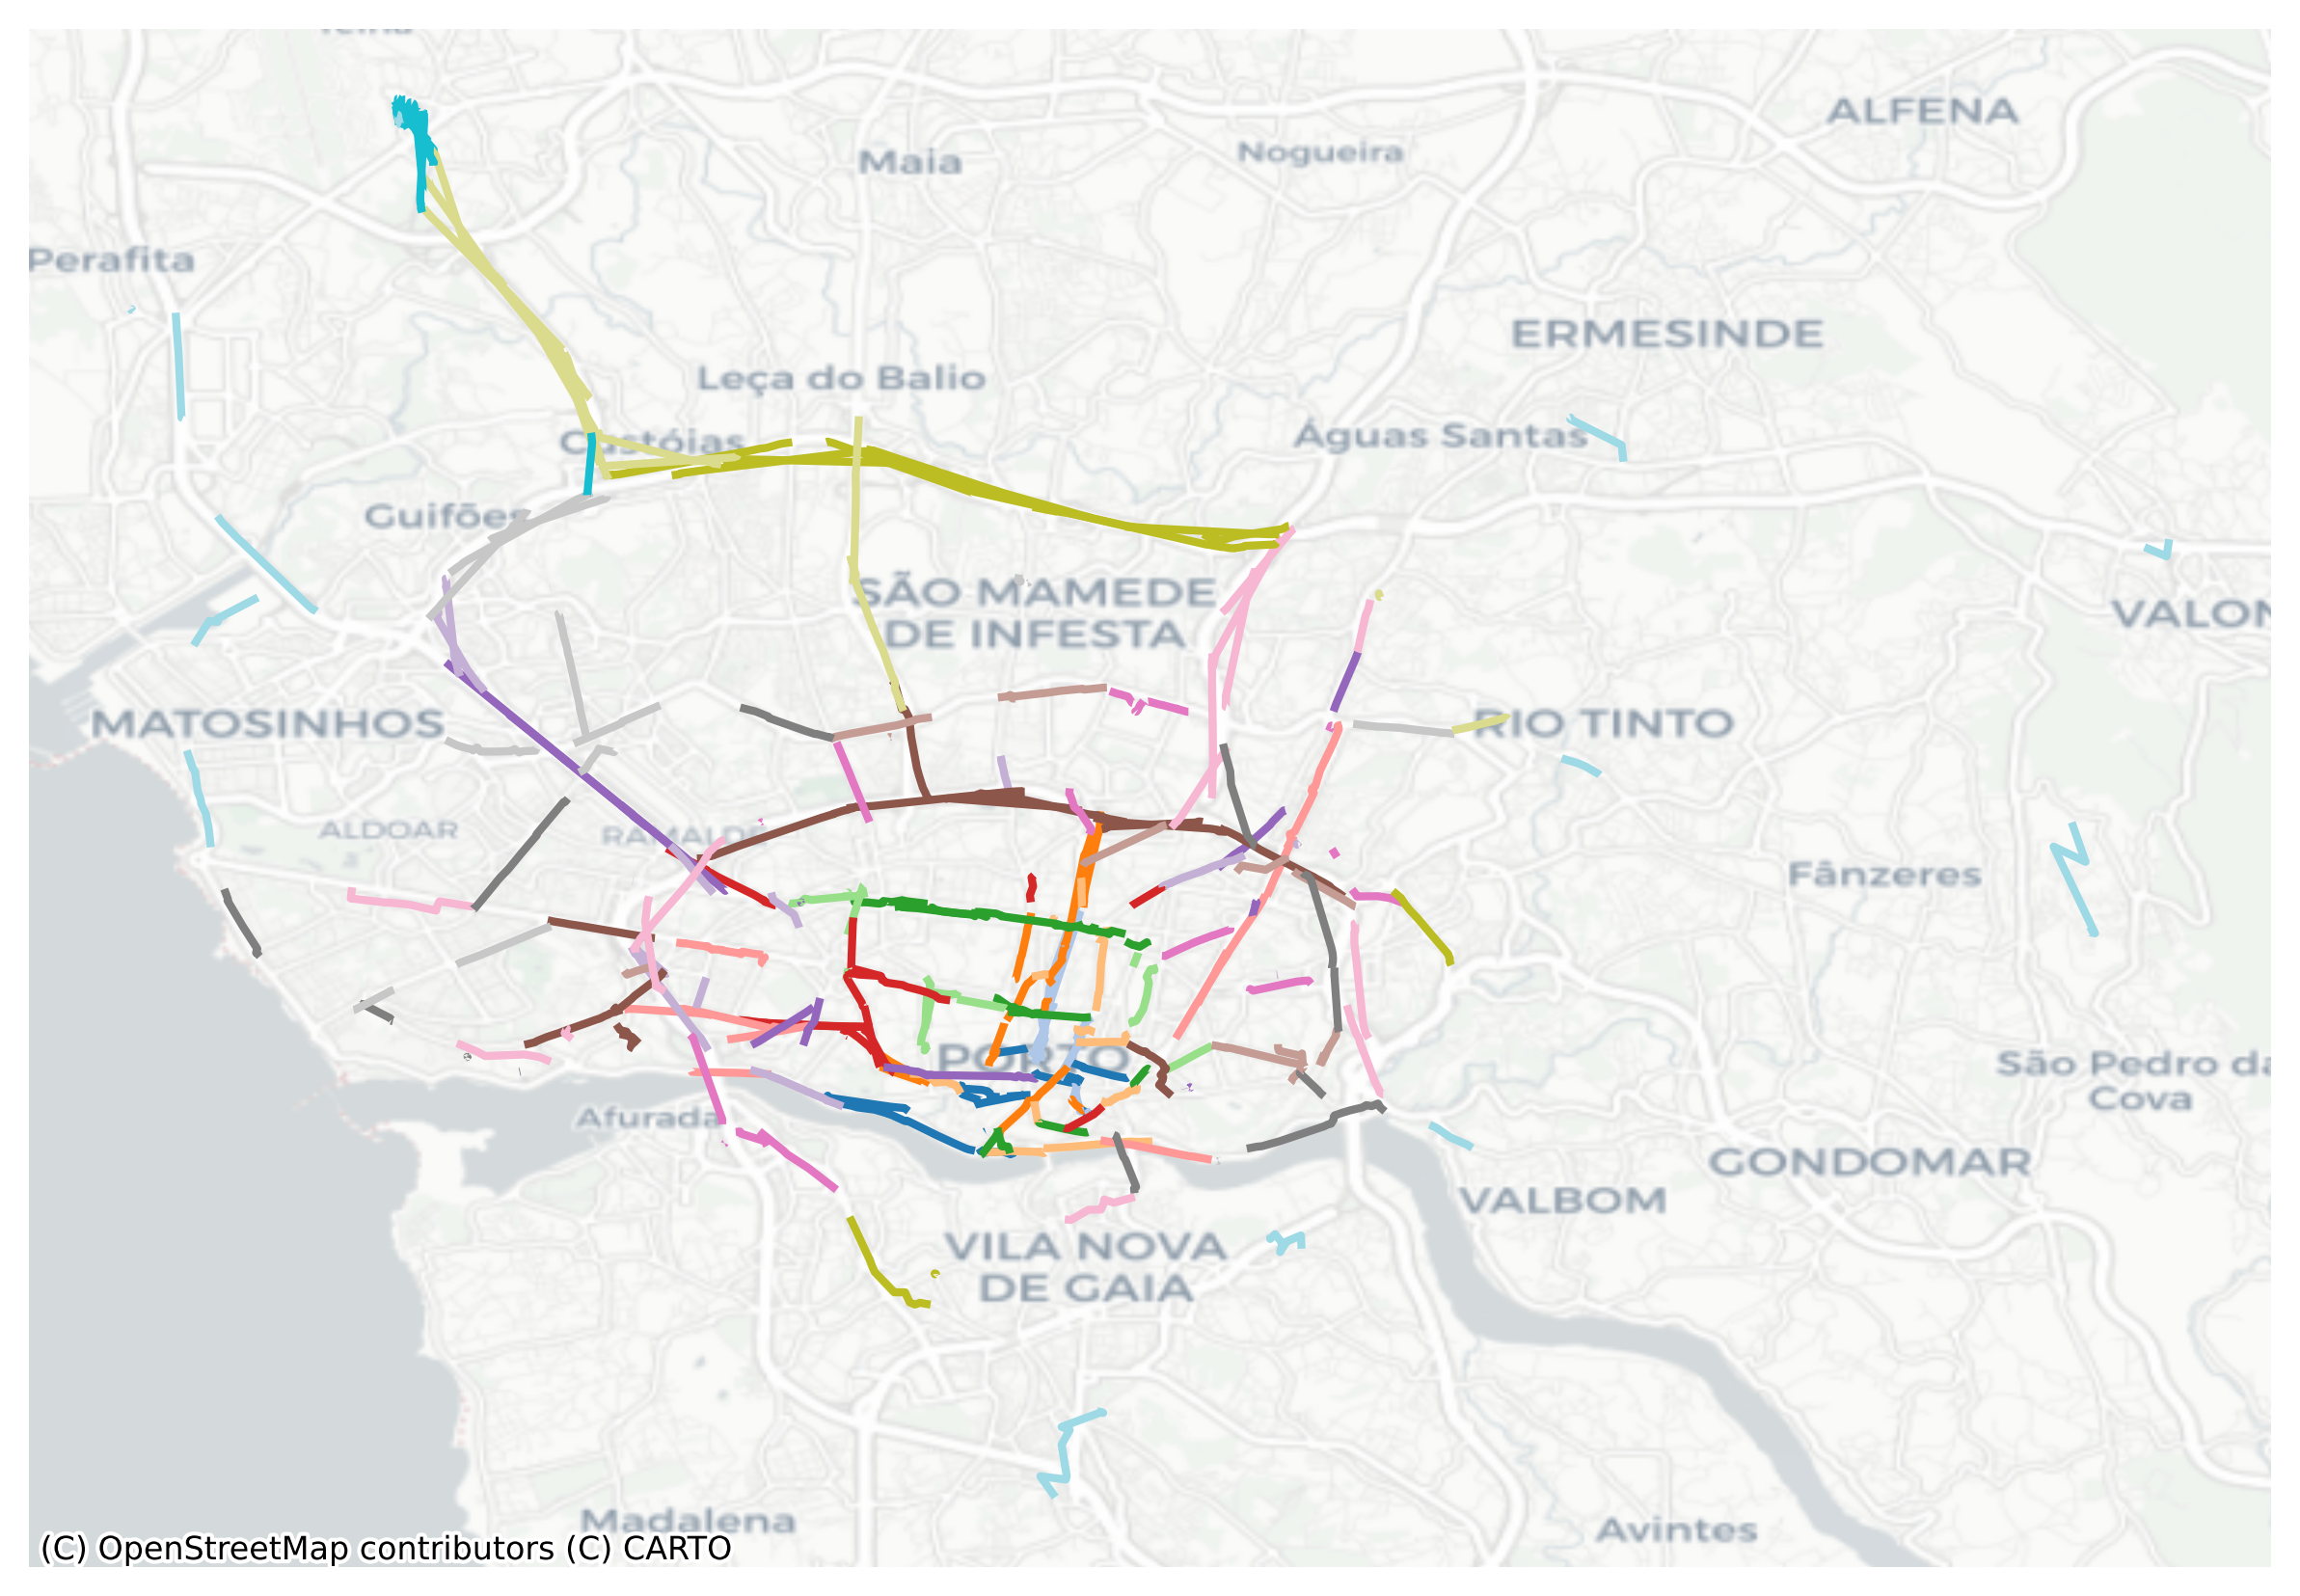

In [ ]:
plot_map_colour(representative_clusters)